In [1]:
import geopandas as gpd
import pandas as pd

import networkx as nx
import osmnx as ox

import numpy as np
import matplotlib.pyplot as plt
import folium

import os
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString
from descartes import PolygonPatch

<h2>Adding Datasets</h2>

<h3>Vector Datasets</h3>

In [2]:
#Amsterdam City Boundary Polygon
url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_GEBIED&THEMA=gebiedsindeling"
aNeighborhood = gpd.read_file(url)
aNeighborhood = aNeighborhood.to_crs('EPSG:32632')
amCity = aNeighborhood.dissolve()

In [3]:
#Amsterdam Bike Facilities
aGraph = ox.load_graphml('./data/Agraph.graphml')

<h3>Plots</h3>

<Axes: >

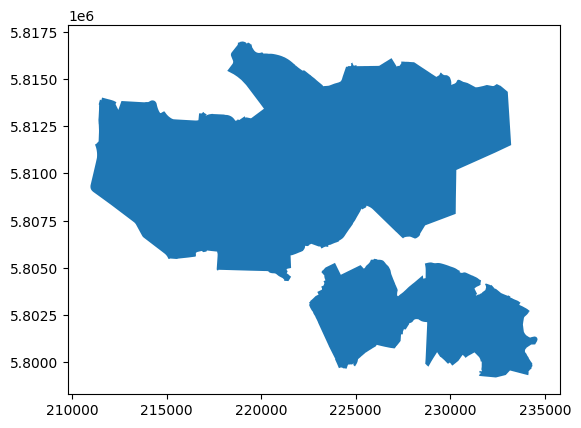

In [4]:
amCity.plot()

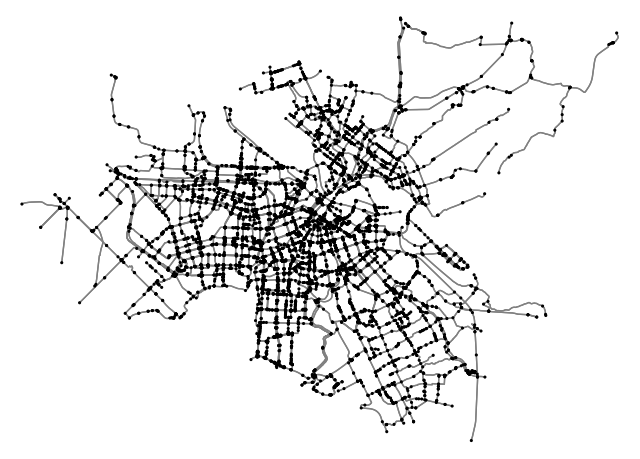

In [5]:
fig, ax = ox.plot_graph(aGraph, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

<h2>Isochrone Polygons</h2>

In [6]:
#seattledf = pd.DataFrame({"City": ["Seattle"], "Latitude": [47.605465173774206], "Longitude": [-122.3192423656039],})
#sPoint = gpd.GeoDataFrame(seattledf, geometry=gpd.points_from_xy(seattledf.Longitude, seattledf.Latitude), crs='EPSG:32610')
#sPoint = sPoint.to_crs('EPSG:32610')
#sCoords = [sPoint['geometry'].y.values[0], sPoint['geometry'].x.values[0]]
#sNode = ox.distance.nearest_nodes(sGraph, X=sCoords[1], Y=sCoords[0], return_dist=False)

In [7]:
#maybe need to reporject graph
#graph_proj = ox.project_graph(g, to_crs=None)

In [8]:
aCoords = [47.605465173774206, -122.3192423656039]
aNode = ox.distance.nearest_nodes(aGraph, X=aCoords[1], Y=aCoords[0], return_dist=False)

In [9]:
nodes = ox.graph_to_gdfs(aGraph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(aGraph, nodes=False, edges=True)

In [10]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in aGraph.edges.data():
    data['time'] = data['length'] / meters_per_minute

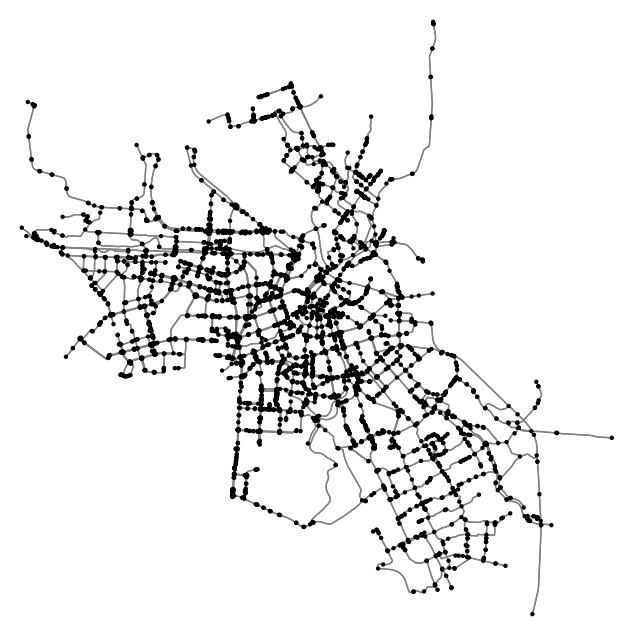

In [11]:
subgraph = nx.ego_graph(aGraph, aNode, radius=360, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [12]:
trip_times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_83386/2306092675.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [13]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph1 = nx.ego_graph(aGraph, aNode, radius=trip_time, distance="time")
    for node in subgraph1.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in aGraph.nodes()]
ns = [10 if node in node_colors else 0 for node in aGraph.nodes()]

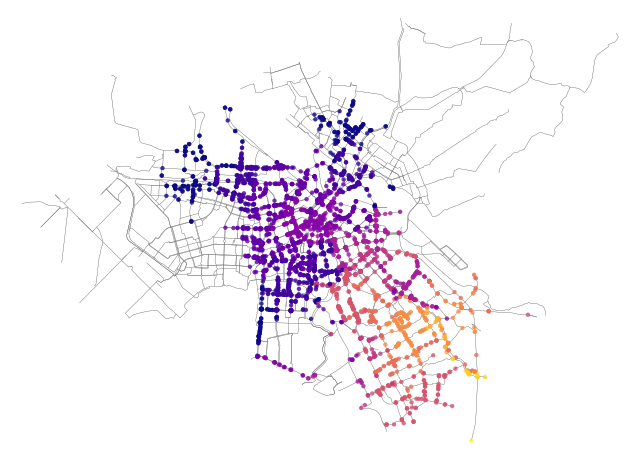

In [14]:
fig, ax = ox.plot_graph(aGraph, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [17]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, aNode, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [18]:
isochrone_polys = make_iso_polys(aGraph, edge_buff=25, node_buff=0, infill=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_83386/290887270.py:20: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union


AttributeError: 'NoneType' object has no attribute 'exterior'

NameError: name 'isochrone_polys' is not defined

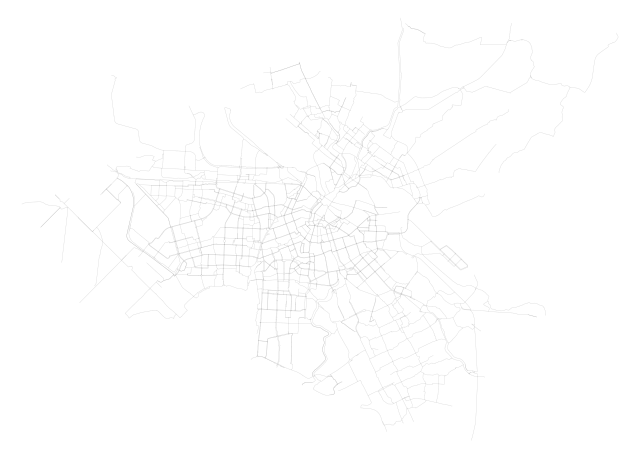

In [20]:
fig, ax = ox.plot_graph(aGraph, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

<h2>Accessibility Calculations</h2>

In [21]:
aArea = amCity.area/1000000

In [22]:
min10 = isochrone_polys[-1]
area10 = min10.area/1000000
per10 = area10/aArea
print(f'{per10[0]:.2f}% of Amsterdam is accessibile by bike within 10 minutes from the city center.')

NameError: name 'isochrone_polys' is not defined

In [ ]:
min30 = isochrone_polys[-3]
area30 = min30.area/1000000
area30
per30 = area30/aArea
print(f'{per30[0]:.2f}% of Amsterdam is accessibile by bike within 30 minutes from the city center.')

In [ ]:
min60 = isochrone_polys[-6]
area60 = min60.area/1000000
area60
per60 = area60/aArea
print(f'{per60[0]:.2f}% of Amsterdam is accessibile by bike within 60 minutes from the city center.')

In [ ]:
min90 = isochrone_polys[3]
area90 = min90.area/1000000
area90
per90 = area90/aArea
print(f'{per90[0]:.2f}% of Amsterdam is accessibile by bike within 90 minutes from the city center.')

In [ ]:
min120 = isochrone_polys[0]
area120 = min120.area/1000000
area120
per120 = area120/aArea
print(f'{per120[0]:.2f}% of Amsterdam is accessibile by bike within 120 minutes from the city center.')